# Nortek AD2CP Processing Code
##### jgradone@marine.rutgers.edu     01/11/2022    Initial

This Jupyter Notebook is intended to read in AD2CP data processed to NetCDFs using the Nortek MIDAS software. The plan will eventually be to seperate a lot of these steps into different functions in a cleaned up packaged that can be published on GitHub but for now, this notebook will include most troubleshooting/processing steps here.

In [1]:
# Imports
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import dirname, join as pjoin
import glob
import netCDF4 as nc
import math
import datetime
import cartopy.crs as ccrs
import xarray as xr
from RU29_helpers import grid_glider
import dbdreader
import matplotlib.dates as mdates
import cmocean.cm as cmo

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Set path for where all the data lives

In [2]:
path = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/Nortek_Recovered/processed/'

files = glob.glob(path+'*.nc')
files = np.sort(files)

## Load data

In [3]:
# Load in the first dataset first and then merge to subsequent ones..... someone tell me a better way to do this

ds = nc.Dataset(files[1])
### Starting with just file 1 for testing
#ds = nc.Dataset(files[0])


tm                 = np.array(ds['Data']['Burst'].variables['time'])
tm                 = pd.to_datetime(tm, unit='s').values
pressure           = np.array(ds['Data']['Burst'].variables['Pressure'])
heading            = np.array(ds['Data']['Burst'].variables['Heading'])
pitch              = np.array(ds['Data']['Burst'].variables['Pitch'])
roll               = np.array(ds['Data']['Burst'].variables['Roll'])
roll               = roll-180 # Note: the AD2CP baseline roll is at 180 so must subtract 180 from roll first
bins               = np.array(ds['Data']['Burst'].variables['Velocity Range'])
speedofsound       = np.array(ds['Data']['Burst'].variables['SpeedOfSound'])
error              = np.array(ds['Data']['Burst'].variables['Error'])
status             = np.array(ds['Data']['Burst'].variables['Status'])
cellsize           = np.array(ds['Data']['Burst'].variables['CellSize'])
numberofcells      = np.array(ds['Data']['Burst'].variables['NumberofCells'])
blanking           = np.array(ds['Data']['Burst'].variables['Blanking'])
nominalcorrelation = np.array(ds['Data']['Burst'].variables['NominalCorrelation'])
ambiguity          = np.array(ds['Data']['Burst'].variables['Ambiguity'])
ensemblecount      = np.array(ds['Data']['Burst'].variables['EnsembleCount'])
unshiftedroll      = np.array(ds['Data']['Burst'].variables['UnshiftedRoll'])

#################################
## What to do about this.....
#################################
#ahrsrotationmatrix = np.array(ds['Data']['Burst'].variables['AHRSRotationMatrix'])

magnetometerx = np.array(ds['Data']['Burst'].variables['MagnetometerX'])
magnetometery = np.array(ds['Data']['Burst'].variables['MagnetometerY'])
magnetometerz = np.array(ds['Data']['Burst'].variables['MagnetometerZ'])

accelerometerx = np.array(ds['Data']['Burst'].variables['AccelerometerX'])
accelerometery = np.array(ds['Data']['Burst'].variables['AccelerometerY'])
accelerometerz = np.array(ds['Data']['Burst'].variables['AccelerometerZ'])

beam1vel = np.array(ds['Data']['Burst'].variables['VelocityBeam1']).transpose()
beam2vel = np.array(ds['Data']['Burst'].variables['VelocityBeam2']).transpose()
beam3vel = np.array(ds['Data']['Burst'].variables['VelocityBeam3']).transpose()
beam4vel = np.array(ds['Data']['Burst'].variables['VelocityBeam4']).transpose()

beam1cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam1']).transpose()
beam2cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam2']).transpose()
beam3cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam3']).transpose()
beam4cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam4']).transpose()

beam1amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam1']).transpose()
beam2amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam2']).transpose()
beam3amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam3']).transpose()
beam4amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam4']).transpose()



# df = xr.Dataset(
#     {"heading" : (("time"), heading),
#      "depth" : (("time"), pressure),
#      "pitch" : (("time"), pitch),
#      "roll" : (("time"), roll),
#      "speedofsound" : (("time"), speedofsound),
#      "error" : (("time"), error),
#      "status" : (("time"), status),
#      "cellsize" : (("time"), cellsize),
#      "numberofcells" : (("time"), numberofcells),
#      "blanking" : (("time"), blanking),
#      "nominalcorrelation" : (("time"), nominalcorrelation),
#      "ambiguity" : (("time"), ambiguity),
#      "ensemblecount" : (("time"), ensemblecount),
#      "unshiftedroll" : (("time"), unshiftedroll),
#      #"ahrsrotationmatrix" : (("time"), ahrsrotationmatrix),
     
#      "magnetometerx" : (("time"), magnetometerx),
#      "magnetometery" : (("time"), magnetometery),
#      "magnetometerz" : (("time"), magnetometerz),
#      "accelerometerx" : (("time"), accelerometerx),
#      "accelerometery" : (("time"), accelerometery),
#      "accelerometerz" : (("time"), accelerometerz),     
     
#      "beam1vel" : (("bins","time"),beam1vel),
#      "beam2vel" : (("bins","time"),beam2vel),
#      "beam3vel" : (("bins","time"),beam3vel),
#      "beam4vel" : (("bins","time"),beam4vel),
#      "beam1cor" : (("bins","time"),beam1cor),
#      "beam2cor" : (("bins","time"),beam2cor),
#      "beam3cor" : (("bins","time"),beam3cor),
#      "beam4cor" : (("bins","time"),beam4cor),
#      "beam1amp" : (("bins","time"),beam1amp),
#      "beam2amp" : (("bins","time"),beam2amp),
#      "beam3amp" : (("bins","time"),beam3amp),
#      "beam4amp" : (("bins","time"),beam4amp)},    
#              coords   = {"bins":bins,"time":tm}
#                        )


# for x in np.arange(1,len(files)):
#     ds = nc.Dataset(files[x])
    
#     tm                 = np.array(ds['Data']['Burst'].variables['time'])
#     tm                 = pd.to_datetime(tm, unit='s').values
#     pressure           = np.array(ds['Data']['Burst'].variables['Pressure'])
#     heading            = np.array(ds['Data']['Burst'].variables['Heading'])
#     pitch              = np.array(ds['Data']['Burst'].variables['Pitch'])
#     roll               = np.array(ds['Data']['Burst'].variables['Roll'])
#     roll               = roll-180 # Note: the AD2CP baseline roll is at 180 so must subtract 180 from roll first
#     bins               = np.array(ds['Data']['Burst'].variables['Velocity Range'])
#     speedofsound       = np.array(ds['Data']['Burst'].variables['SpeedOfSound'])
#     error              = np.array(ds['Data']['Burst'].variables['Error'])
#     status             = np.array(ds['Data']['Burst'].variables['Status'])
#     cellsize           = np.array(ds['Data']['Burst'].variables['CellSize'])
#     numberofcells      = np.array(ds['Data']['Burst'].variables['NumberofCells'])
#     blanking           = np.array(ds['Data']['Burst'].variables['Blanking'])
#     nominalcorrelation = np.array(ds['Data']['Burst'].variables['NominalCorrelation'])
#     ambiguity          = np.array(ds['Data']['Burst'].variables['Ambiguity'])
#     ensemblecount      = np.array(ds['Data']['Burst'].variables['EnsembleCount'])
#     unshiftedroll      = np.array(ds['Data']['Burst'].variables['UnshiftedRoll'])
#     #ahrsrotationmatrix = np.array(ds['Data']['Burst'].variables['AHRSRotationMatrix'])

#     magnetometerx = np.array(ds['Data']['Burst'].variables['MagnetometerX'])
#     magnetometery = np.array(ds['Data']['Burst'].variables['MagnetometerY'])
#     magnetometerz = np.array(ds['Data']['Burst'].variables['MagnetometerZ'])

#     accelerometerx = np.array(ds['Data']['Burst'].variables['AccelerometerX'])
#     accelerometery = np.array(ds['Data']['Burst'].variables['AccelerometerY'])
#     accelerometerz = np.array(ds['Data']['Burst'].variables['AccelerometerZ'])

#     beam1vel = np.array(ds['Data']['Burst'].variables['VelocityBeam1']).transpose()
#     beam2vel = np.array(ds['Data']['Burst'].variables['VelocityBeam2']).transpose()
#     beam3vel = np.array(ds['Data']['Burst'].variables['VelocityBeam3']).transpose()
#     beam4vel = np.array(ds['Data']['Burst'].variables['VelocityBeam4']).transpose()

#     beam1cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam1']).transpose()
#     beam2cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam2']).transpose()
#     beam3cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam3']).transpose()
#     beam4cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam4']).transpose()

#     beam1amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam1']).transpose()
#     beam2amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam2']).transpose()
#     beam3amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam3']).transpose()
#     beam4amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam4']).transpose()
    
#     df2 = xr.Dataset(
#     {"heading" : (("time"), heading),
#      "depth" : (("time"), pressure),
#      "pitch" : (("time"), pitch),
#      "roll" : (("time"), roll),
#      "speedofsound" : (("time"), speedofsound),
#      "error" : (("time"), error),
#      "status" : (("time"), status),
#      "cellsize" : (("time"), cellsize),
#      "numberofcells" : (("time"), numberofcells),
#      "blanking" : (("time"), blanking),
#      "nominalcorrelation" : (("time"), nominalcorrelation),
#      "ambiguity" : (("time"), ambiguity),
#      "ensemblecount" : (("time"), ensemblecount),
#      "unshiftedroll" : (("time"), unshiftedroll),
#      #"ahrsrotationmatrix" : (("time"), ahrsrotationmatrix),
     
#      "magnetometerx" : (("time"), magnetometerx),
#      "magnetometery" : (("time"), magnetometery),
#      "magnetometerz" : (("time"), magnetometerz),
#      "accelerometerx" : (("time"), accelerometerx),
#      "accelerometery" : (("time"), accelerometery),
#      "accelerometerz" : (("time"), accelerometerz),     
     
#      "beam1vel" : (("bins","time"),beam1vel),
#      "beam2vel" : (("bins","time"),beam2vel),
#      "beam3vel" : (("bins","time"),beam3vel),
#      "beam4vel" : (("bins","time"),beam4vel),
#      "beam1cor" : (("bins","time"),beam1cor),
#      "beam2cor" : (("bins","time"),beam2cor),
#      "beam3cor" : (("bins","time"),beam3cor),
#      "beam4cor" : (("bins","time"),beam4cor),
#      "beam1amp" : (("bins","time"),beam1amp),
#      "beam2amp" : (("bins","time"),beam2amp),
#      "beam3amp" : (("bins","time"),beam3amp),
#      "beam4amp" : (("bins","time"),beam4amp)},    
#              coords   = {"bins":bins,"time":tm}
#                        )
    
#     df = xr.merge([df, df2])

## Take a quick peak at some data

In [4]:
# [x,y]=np.meshgrid(df.time,df.bins)
# [bdepth,bbins]=np.meshgrid(df.depth,df.bins)

# by=bdepth+bbins

# fig = plt.figure(figsize=(25,12))

# plt.pcolormesh(x[:,1326700:1328000],-by[:,1326700:1328000],df.beam1cor[:,1326700:1328000])
# plt.plot(df.time[1326700:1328000],-df.depth[1326700:1328000],'k')
# plt.colorbar(label='Beam 1 Correlation')
# plt.gca().xaxis.set_major_formatter(myFmtlong)

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


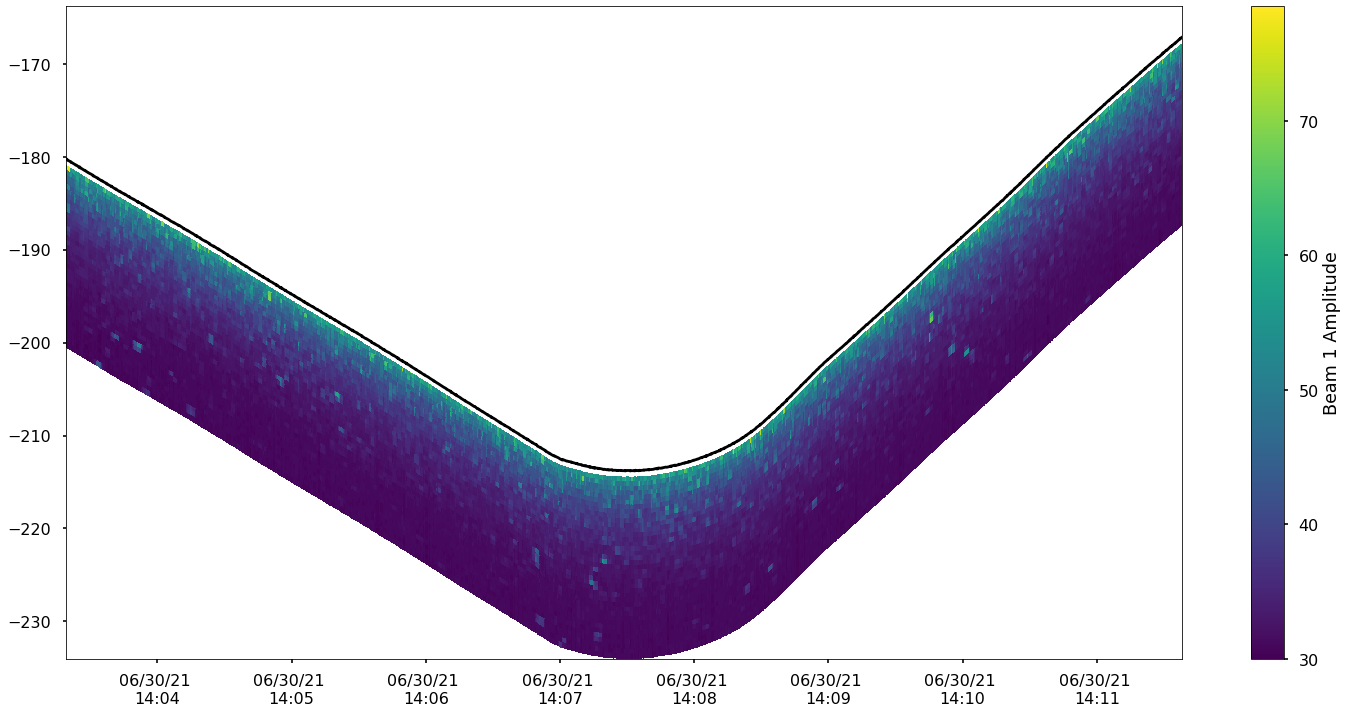

In [5]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4amp[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# ONLY TESTING THIS ON A SUBSET OF DATA FOR NOW, WILL EVENTUALLY NEED TO CHANGE ALL VARIABLE NAMES TO HAVE "DF." AS THE PREFIX !!!!!

## QAQC Steps

### Step 1: Pitch Dependent Magnetic Correction for Heading
The pitch of the glider changes by moving the pitch-battery pack. The pitch-battery produces a magnetic field so when it moves, the field moves and this effects our compass data. Having all of the data from a mission loaded in for this correction ensures the best fit possible.

### Step 2: QAQC Pre-Coordinate Transformation

#### Remove any bin and bin further away from it that returns an amplitude within 3dB of the noise floor.
We also need to calculate the noise floor. This method is recommended by the manual.

In [6]:
# Define pitch threshold, this will be used later on too.
pitch_threshold = 15

# Define noise floor
nf = 25 # [dB], reported by Nortek by sampling in air.

# SNR_dB = S_dB - N_dB use 13 dB as threshold from Todd 2017
snr_threshold = 13

for i in np.arange(0,beam1amp.shape[1]):
    if pitch[i] > pitch_threshold: # Upcast so use beams 234
        # Calculate SNR for each beam
        snr2 = beam2amp[:,i]-nf
        snr3 = beam3amp[:,i]-nf
        snr4 = beam4amp[:,i]-nf
        
        # If SNR < threshold in a bin in any beam, make that bin nan in all beams needed for this cast
        snr2_ind = snr2 < snr_threshold 
        snr3_ind = snr3 < snr_threshold 
        snr4_ind = snr4 < snr_threshold
        snr_ind  = []
        snr_ind  = snr2_ind + snr3_ind + snr4_ind
        beam2amp[snr_ind,i] = np.NaN
        beam3amp[snr_ind,i] = np.NaN
        beam4amp[snr_ind,i] = np.NaN
    elif pitch[i] < -pitch_threshold: # Downcast so use beams 124
        # Calculate SNR for each beam
        snr1 = beam1amp[:,i]-nf
        snr2 = beam2amp[:,i]-nf
        snr4 = beam4amp[:,i]-nf
        
        # If SNR < threshold in a bin in any beam, make that bin nan in all beams needed for this cast
        snr1_ind = snr1 < snr_threshold 
        snr2_ind = snr2 < snr_threshold 
        snr4_ind = snr4 < snr_threshold 
        snr_ind  = []
        snr_ind  = snr1_ind + snr2_ind + snr4_ind
        beam1amp[snr_ind,i] = np.NaN
        beam2amp[snr_ind,i] = np.NaN
        beam4amp[snr_ind,i] = np.NaN


#### Check how much data we lost in each beam

In [7]:
print((np.sum(np.isnan(beam1amp))/np.size(beam1amp))*100)
print((np.sum(np.isnan(beam2amp))/np.size(beam2amp))*100)
print((np.sum(np.isnan(beam3amp))/np.size(beam3amp))*100)
print((np.sum(np.isnan(beam4amp))/np.size(beam4amp))*100)


40.38298647395611
67.92256008713186
27.53957361317575
67.92256008713186


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


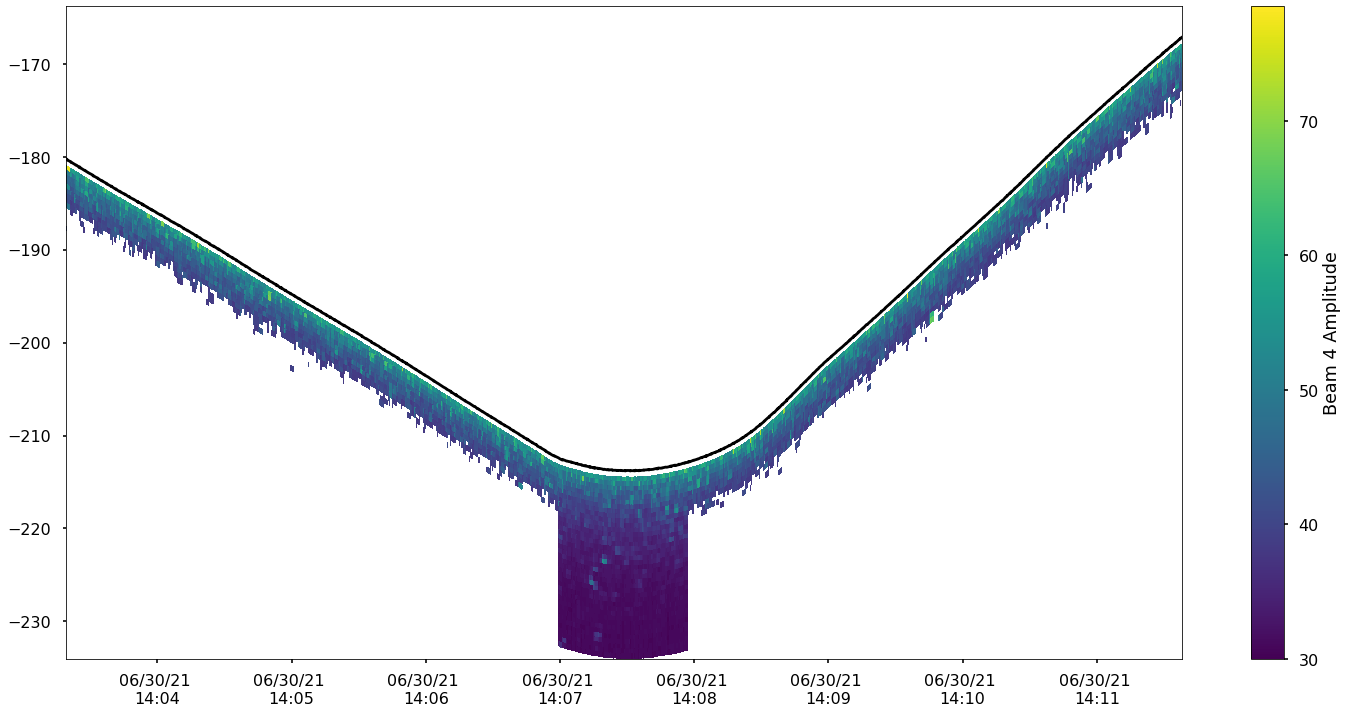

In [8]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4amp[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 4 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

#### Remove extreme amplitude returns

In [9]:
# Set extreme threshold
max_return = 75 # [dB]

for i in np.arange(0,beam1amp.shape[1]):
    if pitch[i] > pitch_threshold: # Upcast so use beams 234
        # If the return is above the threshold, flag the data
        amp2_ind = beam2amp[:,i] > max_return 
        amp3_ind = beam3amp[:,i] > max_return 
        amp4_ind = beam4amp[:,i] > max_return
        amp_ind  = []
        amp_ind  = amp2_ind + amp3_ind + amp4_ind
        beam2amp[amp_ind,i] = np.NaN
        beam3amp[amp_ind,i] = np.NaN
        beam4amp[amp_ind,i] = np.NaN
    elif pitch[i] < -pitch_threshold: # Downcast so use beams 124
        # If the return is above the threshold, flag the data
        amp1_ind = beam1amp[:,i] > max_return 
        amp2_ind = beam2amp[:,i] > max_return 
        amp4_ind = beam4amp[:,i] > max_return
        amp_ind  = []
        amp_ind  = amp1_ind + amp2_ind + amp4_ind
        beam1amp[amp_ind,i] = np.NaN
        beam2amp[amp_ind,i] = np.NaN
        beam4amp[amp_ind,i] = np.NaN


#### Check how much data we lost in each beam

In [10]:
print((np.sum(np.isnan(beam1amp))/np.size(beam1amp))*100)
print((np.sum(np.isnan(beam2amp))/np.size(beam2amp))*100)
print((np.sum(np.isnan(beam3amp))/np.size(beam3amp))*100)
print((np.sum(np.isnan(beam4amp))/np.size(beam4amp))*100)


40.4780845708903
68.11820202228338
27.64011745139308
68.11820202228338


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


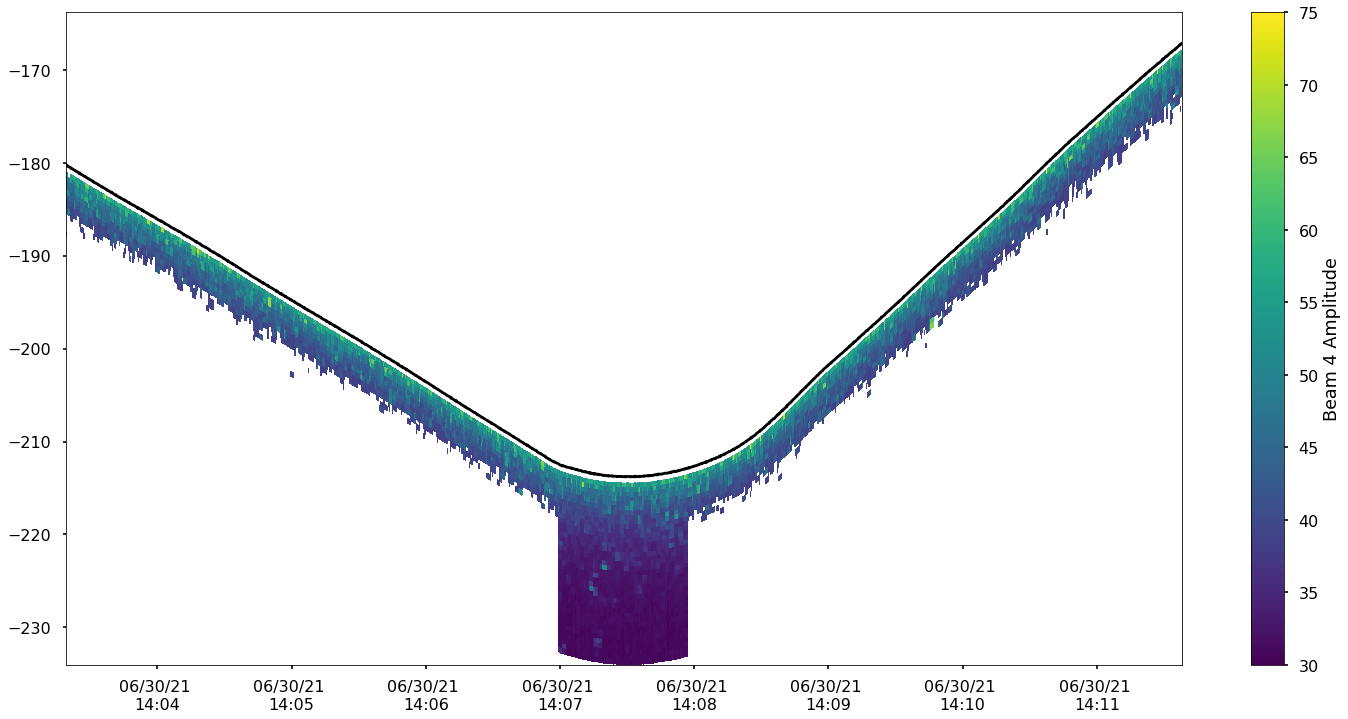

In [11]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4amp[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 4 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

### Up until this point, filtering applying to beam amplitudes. Now we need to turn corresponding beam velocities to NaN where beam amplitudes are set to NaN

In [12]:
beam1vel[np.isnan(beam1amp)] = np.NaN
beam2vel[np.isnan(beam2amp)] = np.NaN
beam3vel[np.isnan(beam3amp)] = np.NaN
beam4vel[np.isnan(beam4amp)] = np.NaN

In [13]:
print((np.sum(np.isnan(beam1vel))/np.size(beam1vel))*100)
print((np.sum(np.isnan(beam2vel))/np.size(beam2vel))*100)
print((np.sum(np.isnan(beam3vel))/np.size(beam3vel))*100)
print((np.sum(np.isnan(beam4vel))/np.size(beam4vel))*100)

40.4780845708903
68.11820202228338
27.64011745139308
68.11820202228338


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


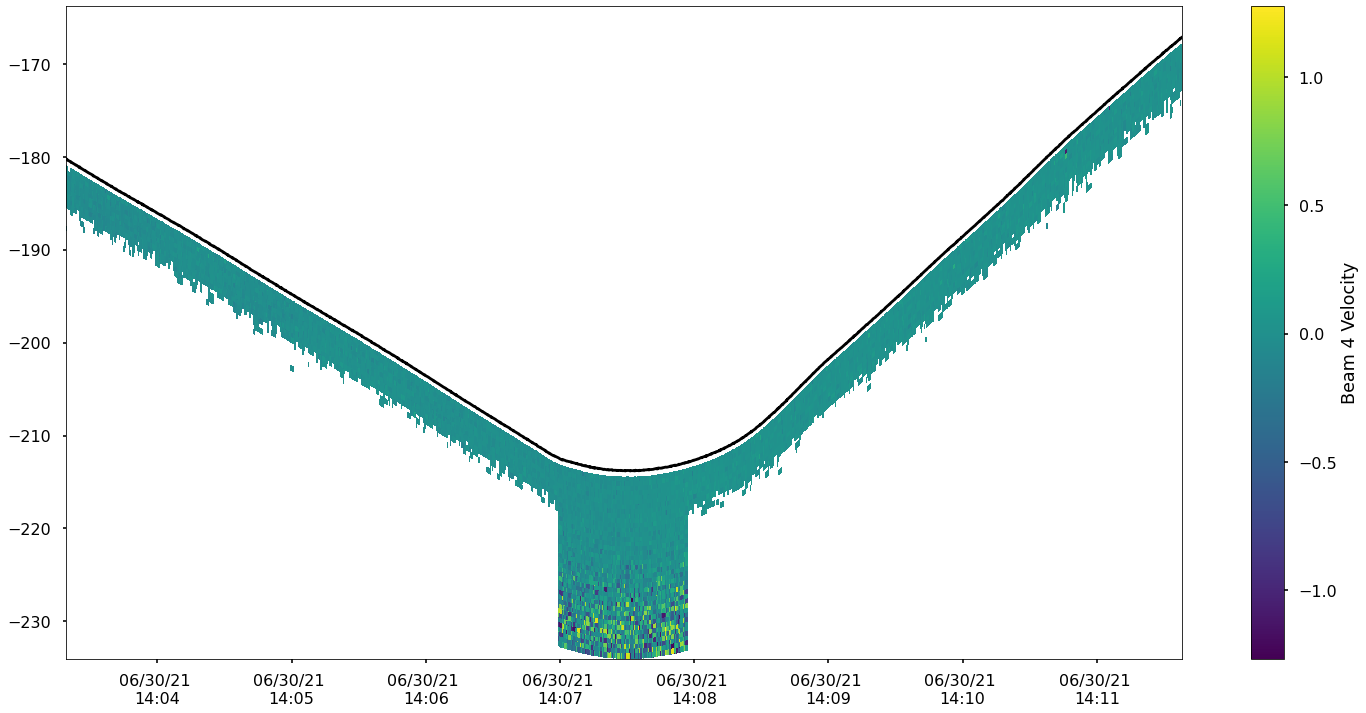

In [14]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4vel[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 4 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

#### Extreme Pitch and Roll Filter
Greater than +/- 15 degrees pitch for dive and climb <br/>
Greater than +/- 10 degrees roll <br /><br />

In [15]:
## Pitch threshold defined previously during isolating up and downcasts. Maybe this is not the most appropriate way to do this?

beam1vel[:,np.abs(pitch) < pitch_threshold] = np.NaN
beam2vel[:,np.abs(pitch) < pitch_threshold] = np.NaN
beam3vel[:,np.abs(pitch) < pitch_threshold] = np.NaN
beam4vel[:,np.abs(pitch) < pitch_threshold] = np.NaN

In [16]:
print((np.sum(np.isnan(beam1vel))/np.size(beam1vel))*100)
print((np.sum(np.isnan(beam2vel))/np.size(beam2vel))*100)
print((np.sum(np.isnan(beam3vel))/np.size(beam3vel))*100)
print((np.sum(np.isnan(beam4vel))/np.size(beam4vel))*100)

46.06364894102409
73.70376639241717
33.22568182152687
73.70376639241717


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


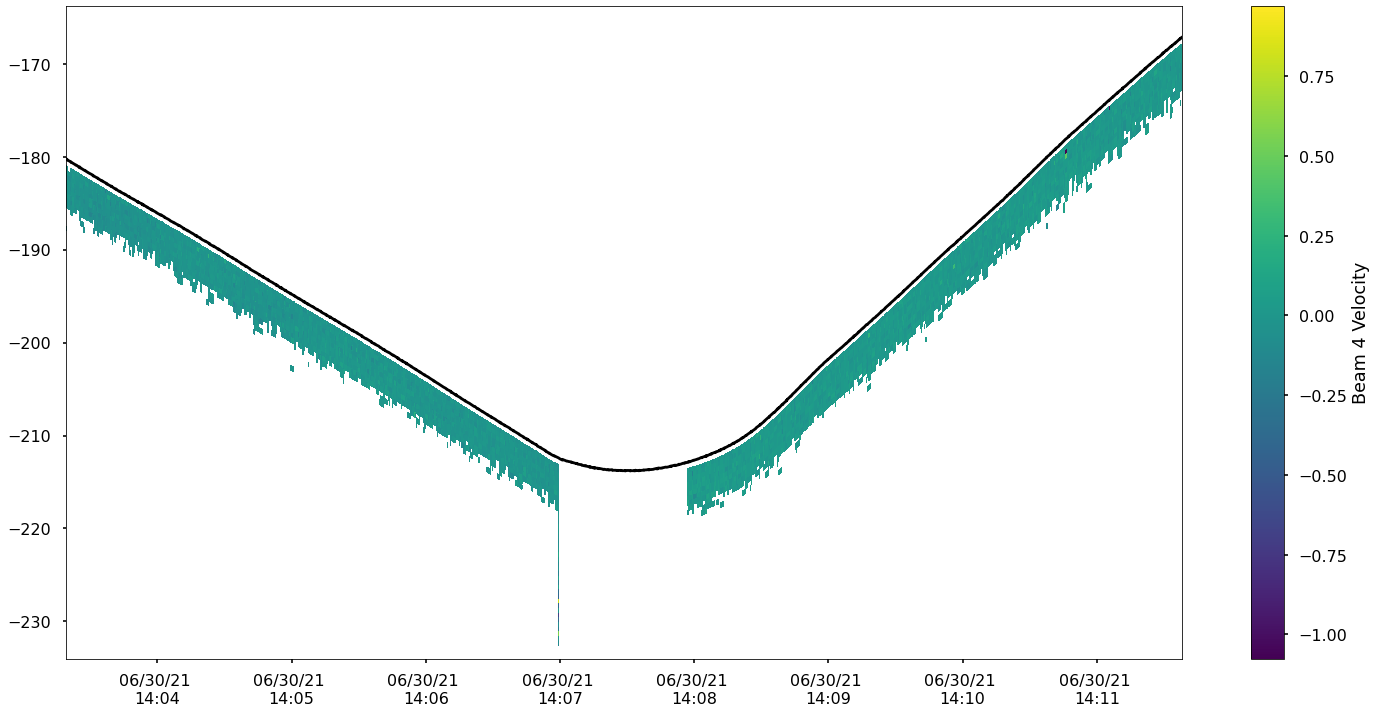

In [17]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4vel[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 4 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [18]:
roll_threshold = 10
beam1vel[:,np.abs(roll) > roll_threshold] = np.NaN
beam2vel[:,np.abs(roll) > roll_threshold] = np.NaN
beam3vel[:,np.abs(roll) > roll_threshold] = np.NaN
beam4vel[:,np.abs(roll) > roll_threshold] = np.NaN

In [19]:
print((np.sum(np.isnan(beam1vel))/np.size(beam1vel))*100)
print((np.sum(np.isnan(beam2vel))/np.size(beam2vel))*100)
print((np.sum(np.isnan(beam3vel))/np.size(beam3vel))*100)
print((np.sum(np.isnan(beam4vel))/np.size(beam4vel))*100)

46.078201580736796
73.71831903212987
33.24775915105309
73.71831903212987


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


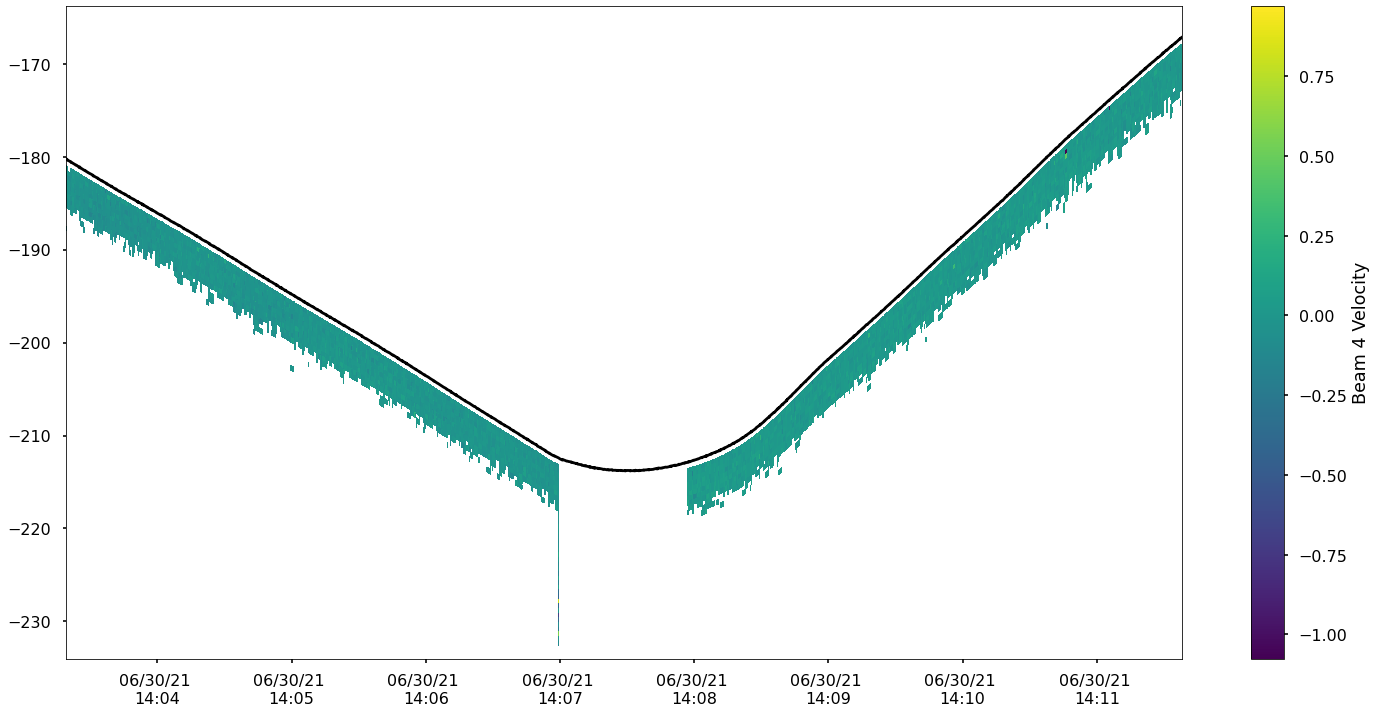

In [20]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4vel[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 4 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

#### Correlation Filter

Reject correlation values less than 0.5 (Todd et al. 2017). Do this directly to beam velocities.

In [21]:
# Set threshold
corr_threshold = 0.5

beam1vel[np.abs(beam1cor) < corr_threshold] = np.NaN
beam2vel[np.abs(beam2cor) < corr_threshold] = np.NaN
beam3vel[np.abs(beam3cor) < corr_threshold] = np.NaN
beam4vel[np.abs(beam4cor) < corr_threshold] = np.NaN

In [22]:
print((np.sum(np.isnan(beam1vel))/np.size(beam1vel))*100)
print((np.sum(np.isnan(beam2vel))/np.size(beam2vel))*100)
print((np.sum(np.isnan(beam3vel))/np.size(beam3vel))*100)
print((np.sum(np.isnan(beam4vel))/np.size(beam4vel))*100)

46.205219816610985
73.73259570522349
33.417717792855775
73.73412272051573


/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


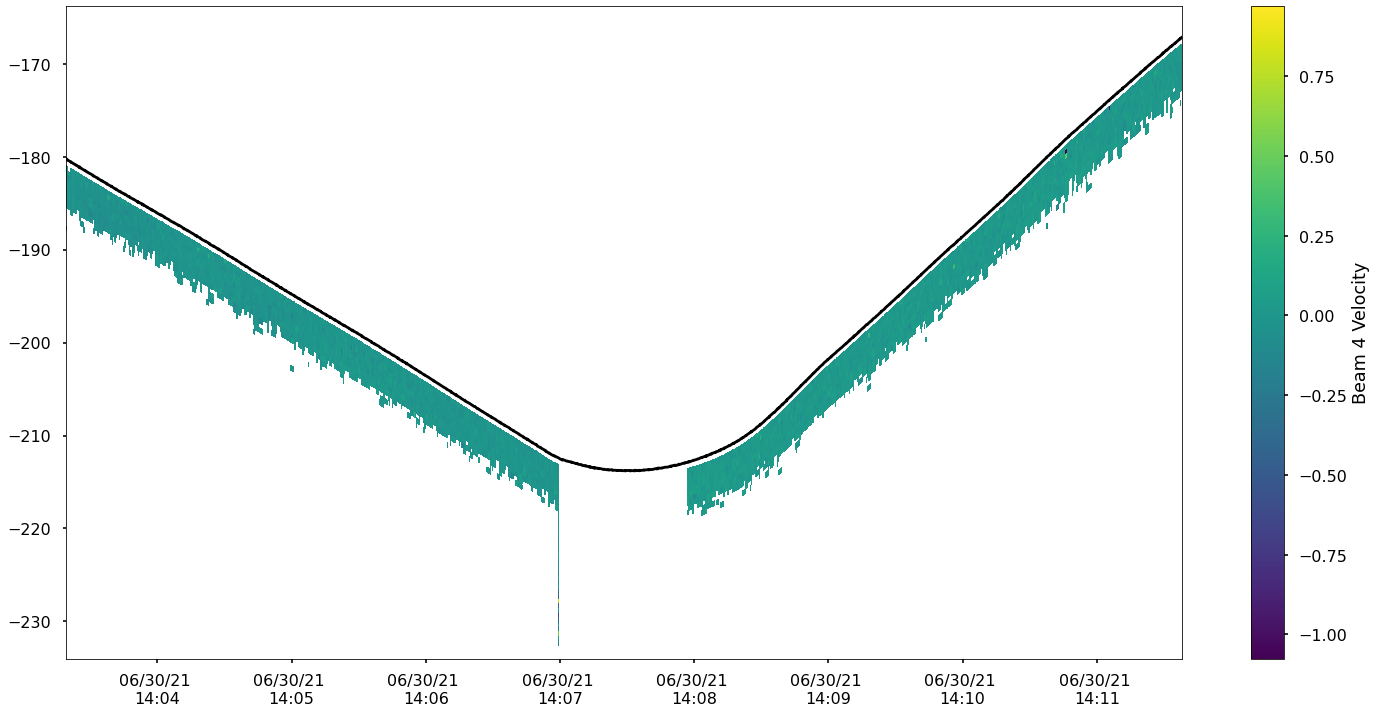

In [23]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,8000:10000],-by[:,8000:10000],beam4vel[:,8000:10000])
plt.plot(tm[8000:10000],-pressure[8000:10000],'k')
plt.colorbar(label='Beam 4 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

### Peak at some deeper data

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


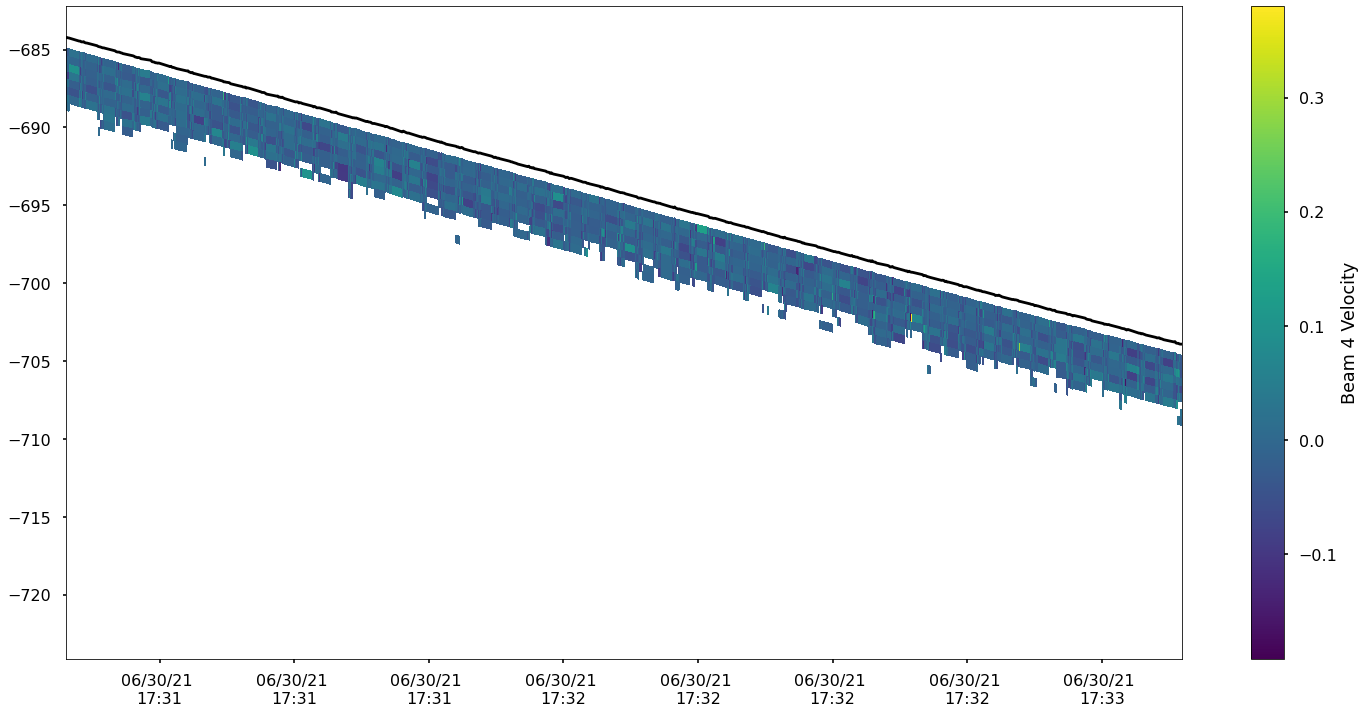

In [24]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,53000:53500],-by[:,53000:53500],beam4vel[:,53000:53500])
plt.plot(tm[53000:53500], -pressure[53000:53500],'k')
plt.colorbar(label='Beam 4 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

### Step 3: Convert from beam to ENU coordinates

In [25]:
## These are two functions I adapted from Sam Coakley's and Nortek's AD2CP MATLAB code.

def cell_vert(pitch, roll, rng_cells):
    # Calculate a vertical displacement below instrument for each adcp bin adjusting for pitch and roll (in degrees)
    # rng_cells is the vector of cell ranges found in the adcp .hdr file
    
    junk = rng_cells * np.sin(np.deg2rad(90-pitch))
    z = junk*np.sin(np.deg2rad(90-roll))
    return z



def Xform(beam,T,hh,pp,rr,statusbit0):
    ## This function is my python conversion of Nortek's Transform.m which is
    ## a Matlab script that shows how velocity data can be transformed between
    ## beam coordinates and ENU coordinates. Beam coordinates are defined as the
    ## velocity measured along the three beams of the instrument. ENU coordinates
    ## are defined in an earth coordinate system, where E represents the East-West
    ## component, N represents the North-South component and U represents the Up-Down component.
    
    ## beam = beam velocities
    ## T = transformation matrix from beam to xyz coordinates
    ## hh = heading
    ## pp = pitch
    ## rr = roll
    ## statusbit0 = 1 means the instrument is pointing down
    
    ## Note that the transformation matrix must be recalculated every time
    ## the orientation, heading, pitch or roll changes.
    
    ## Transformation matrix for beam to xyz coordinates,
    ## the values can be found from the header file that is generated in the
    ## conversion of data to ASCII format
    
    # This example shows the transformation matrix for a standard Aquadopp head
    
    # T = np.matrix([[2896,2896,0],
    #                [-2896,2896,0],
    #                [-2896,-2896,5792]])
    #  T = T/4096   # Scale the transformation matrix correctly to floating point numbers
    
    T_org = T
    
    ## If instrument is pointing down, bit 0 in status is equal to 1, rows 2 and 3 must change sign.
    if statusbit0 == 1:
        T[1,:] = -T[1,:]
        T[2,:] = -T[2,:]
    
    ## Heading, pitch, and roll are the angles output in the data in degrees
    
    hh = np.pi*(hh-90)/180
    pp = np.pi*pp/180
    rr = np.pi*rr/180
    
    ## Make heading matrix
    H = np.matrix([[np.cos(hh), np.sin(hh), 0],
                  [-np.sin(hh), np.cos(hh), 0],
                  [0          ,0          , 1]])         
    
    ## Make tilt matrix
    P = np.matrix([[np.cos(pp), -np.sin(pp)*np.sin(rr), -np.cos(rr)*np.sin(pp)],
                  [0          , np.cos(rr)            , -np.sin(rr)        ],
                  [np.sin(pp) , np.sin(rr)*np.cos(pp) , np.cos(pp)*np.cos(rr)]])
    
    ## Make resulting transportmation matrix
    R = H*P*T
    
    ## beam is beam coordinates, for example beam = np.matrix([0.23, -0.52, 0.12])
    ## enu is ENU coordinates
    
    ## Given beam velocities, ENU coordinates are calculated as:
    enu = R*beam
    
    ############################### Untested ###############################
    ## FYI, given ENU velocities, beam coordinates should be calculated as:
    # beam = np.linalg.inv(R)*enu
    
    ## And the transformation between beam and xyz coordinates can in theory
    ## be done using the original T matrix as:
    # xyz = T_org*beam
    # beam = np.linalg.inv(T_org)*xyz
    
    ## And given ENU velocities, xyz coordinates are calculated as:
    # xyz = T_org*np.linalg.inv(R)*enu
    
    return(enu)



## These are the transformation matricies for up and down cast.
## Left, Rear, Right beams

T234 = np.matrix([[0.505529791933900, -1.35634170490926, 0.50552979193390],
                  [-1.18310079157625, 0                , 1.18310079157625],
                  [0.551688959481250, 0                , 0.55168895948125]])

## Forward, left, right beams
T124 = np.matrix([[1.35634170490926, -0.50552979193390, -0.50552979193390],
                  [0               , -1.18310079157625, 1.183100791576250],
                  [0               , 0.551688959481250, 0.551688959481250]])


In [26]:
## Loop to actually convert beam to ENU velocity

# Initialize final variables with NaNs first
realbindepths    = np.empty([beam1amp.shape[0],beam1amp.shape[1]])
east             = np.empty([beam1amp.shape[0],beam1amp.shape[1]])
north            = np.empty([beam1amp.shape[0],beam1amp.shape[1]])
up               = np.empty([beam1amp.shape[0],beam1amp.shape[1]])
realbindepths[:] = np.NaN
east[:]          = np.NaN
north[:]         = np.NaN
up[:]            = np.NaN


for k in np.arange(0,beam1amp.shape[1]):
    
    # Pull out just a single ping
    V1 = beam1vel[:,k]
    V2 = beam2vel[:,k]
    V3 = beam3vel[:,k]
    V4 = beam4vel[:,k]
    
    # Concat all up/down cast beam data
    beam124 = np.matrix([V1, V2, V4])
    beam234 = np.matrix([V2, V3, V4])
    
    ## Calculate the vertical displacement of the bins adjusting for pitch and roll
    zrng = cell_vert(pitch[k],roll[k],bins)
    zrng = pressure[k] + zrng # this is a real bin depth now
    
    ## Convert the beam velocity data to ENU velocity data.
    ## Only convert the front beams if downcast and back beams for upcast.
    if pitch[k] < -pitch_threshold:
        enu124 = Xform(beam124, T124, heading[k], pitch[k], roll[k], 1)
        
        realbindepths[:,k] = zrng
        east[:,k]          = enu124[0,:]
        north[:,k]         = enu124[1,:]
        up[:,k]            = enu124[2,:]
    elif pitch[k] > pitch_threshold:
        enu234 = Xform(beam234, T234, heading[k], pitch[k], roll[k], 1)
        
        realbindepths[:,k] = zrng
        east[:,k]          = enu124[0,:]
        north[:,k]         = enu124[1,:]
        up[:,k]            = enu124[2,:]


## Striping in the surface, hmmmmm?

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


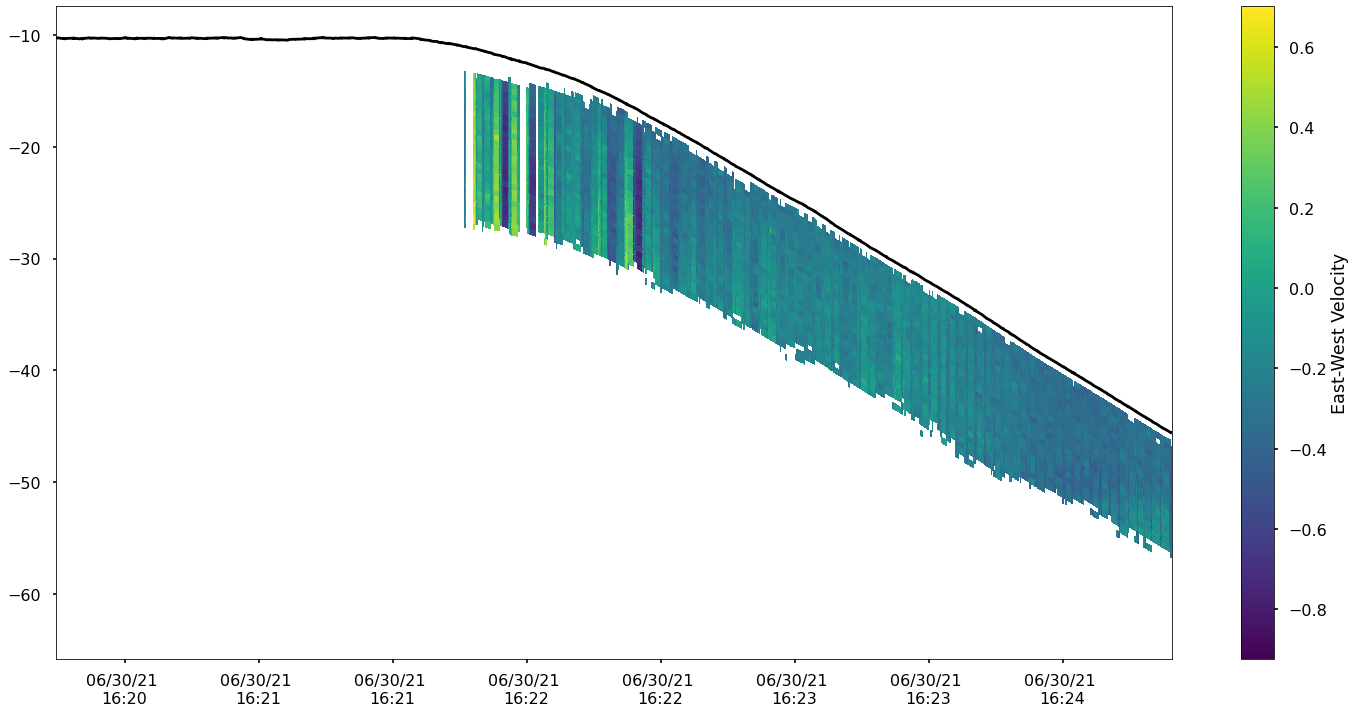

In [27]:
[x,y]=np.meshgrid(tm,bins)
[bdepth,bbins]=np.meshgrid(pressure,bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,36000:37000],-by[:,36000:37000],east[:,36000:37000])
plt.plot(tm[36000:37000], -pressure[36000:37000],'k')
plt.colorbar(label='East-West Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Now it's time to run the inversion!

In [34]:
## Inversion function copied from GitHub repo 01/12/2022
                     
def process_data(U,V,H,dz,u_daverage,v_daverage):
    global O_ls, G_ls, bin_new    
    
    ## Feb-2021 jgradone@marine.rutgers.edu Initial
    ## Jul-2021 jgradone@marine.rutgers.edu Updates for constraints
    
    ## Purpose: Take velocity measurements from glider mounted ADCP and compute
    # shear profiles
    
    ## Outputs:
    # O_ls is the ocean velocity profile
    # G_ls is the glider velocity profile
    # bin_new are the bin centers for the point in the profiles
    # C is the constant used in the constraint equation (Not applicable for
    # real-time processing)
    
    ## Inputs:
    # dz is desired vertical resolution, should not be smaller than bin length
    # H is the max depth of the water column
    # U is measured east-west velocities from ADCP
    # V is measured north-south velocities from ADCP
    # Z is the measurement depths of U and V
    # uv_daverage is depth averaged velocity (Set to 0 for real-time)
    
    ##########################################################################        
    # Take difference between bin lengths for bin size [m]
    bin_size = np.diff(bins)[0]
    bin_num = len(bins)

    # This creates a grid of the ACTUAL depths of the ADCP bins by adding the
    # depths of the ADCP bins to the actual depth of the instrument
    [bdepth,bbins]=np.meshgrid(depth,bins)
    bin_depth = bdepth+bbins  
    Z = bin_depth

    # Set knowns from Equations 19 from Visbeck (2002) page 800
    # Maximum number of observations (nd) is given by the number of velocity
    # estimates per ping (nbin) times the number of profiles per cast (nt)
    nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
    nt   = U.shape[1]  # number of individual velocity profiles
    nd   = nbin*nt      # G dimension (1) 

    # Define the edges of the bins
    bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

    # Check that each bin has data in it
    bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
    bin_count[:] = np.NaN

    for k in np.arange(len(bin_edges))[:-1]:
        # Create index of depth values that fall inside the bin edges
        ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
        bin_count[k] = len(bin_depth[ii])
        ii = []

    # Create list of bin centers    
    bin_new = [x+dz/2 for x in bin_edges[:-1]]

    # Chop off the top of profile if no data
    ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
    bin_new = bin_new[ind:]        # Removes all bins above first with data
    z1 = bin_new[0]                # Depth of center of first bin with data

    # Create and populate G
    nz = len(bin_new)  # number of ocean velocities desired in output profile
    nm = nz + nt       # G dimension (2), number of unknowns
    # Let's build the corresponding coefficient matrix G 
    G = np.zeros((nd,nm))

    # Indexing of the G matrix was taken from Todd et al. 2012
    for ii in np.arange(nbin):           # Number of ADCP profiles per cast
        for jj in np.arange(nt):     # Number of measured bins per profile

            # Uctd part of matrix
            G[(nbin*(ii-1))+jj,ii] = 1

            # This will fill in the Uocean part of the matrix. It loops through
            # all Z members and places them in the proper location in the G matrix

            # Find the difference between all bin centers and the current Z value        
            dx = abs(bin_new-Z[ii,jj])

            # Find the minimum of these differences
            minx = np.nanmin(dx)

            # Finds bin_new index of the first match of Z and bin_new    
            idx = np.argmin(dx-minx)

            G[(nbin*(ii-1))+jj,nt+idx] = 1
            del dx, minx, idx


    # Reshape U and V into the format of the d column vector
    d_u = np.flip(U.transpose(),axis=0)
    d_u = d_u.flatten()
    d_v = np.flip(V.transpose(),axis=0)
    d_v = d_v.flatten()


    ##########################################################################
    ## This chunk of code containts the constraints for depth averaged currents
    ## which we likely won't be using for the real-time processing

    # Need to calculate C (Todd et al. 2017) based on our inputs 
    # This creates a row that has the same # of columns as G. The elements
    # of the row follow the trapezoid rule which is used because of the
    # extension of the first bin with data to the surface. The last entry of
    # the row corresponds to the max depth reached by the glider, any bins
    # below that should have already been removed.

    constraint = np.concatenate(([np.zeros(nt)], [z1/2], [z1/2+dz/2], [[dz]*(nz-3)], [dz/2]), axis=None)

    # To find C, we use the equation of the norm and set norm=1 because we
    # desire unity. The equation requires we take the sum of the squares of the
    # entries in constraint.

    sqr_constraint = constraint*constraint
    sum_sqr_constraint = np.sum(sqr_constraint)

    # Then we can solve for the value of C needed to maintain unity 

    C = H*(1/np.sqrt(sum_sqr_constraint))

    # This is where you would add the constraint for the depth averaged
    # velocity from Todd et al., (2011/2017)

    # OG
    du = np.concatenate(([d_u],[C*u_daverage]), axis=None)
    dv = np.concatenate(([d_v],[C*v_daverage]), axis=None)

    # Build Gstar
    # Keep this out because not using depth averaged currents
    Gstar = np.vstack((G, (C/H)*constraint))

    ##########################################################################

    # Build the d matrix
    d = list(map(complex,du, dv))

    ##### Inversion!
    ## If want to do with a sparse matrix sol'n, look at scipy
    #Gs = scipy.sparse(Gstar)
    Gs = Gstar

    ms = np.linalg.solve(np.dot(Gs.conj().transpose(),Gs),Gs.conj().transpose())

    ## This is a little clunky but I think the dot product fails because of
    ## NaN's in the d vector. So, this code will replace NaN's with 0's just
    ## for that calculation    
    sol = np.dot(ms,np.where(np.isnan(d),0,d))

    O_ls = sol[nt:]   # Ocean velocity
    G_ls = sol[0:nt]  # Glider velocity
    return O_ls, G_ls, bin_new


In [35]:
###################### Should add this to main function......
depth = pressure

process_data(U=east,V=north,H=1500,dz=250,u_daverage=0,v_daverage=0)

IndexError: index 40 is out of bounds for axis 0 with size 40

In [40]:
east.shape

(40, 135886)

In [ ]:
## Inversion function copied from GitHub repo 01/12/2022

depth = pressure

U=east
V=north
H=1500
dz=200
u_daverage=0
v_daverage=0


## Feb-2021 jgradone@marine.rutgers.edu Initial
## Jul-2021 jgradone@marine.rutgers.edu Updates for constraints

## Purpose: Take velocity measurements from glider mounted ADCP and compute
# shear profiles

## Outputs:
# O_ls is the ocean velocity profile
# G_ls is the glider velocity profile
# bin_new are the bin centers for the point in the profiles
# C is the constant used in the constraint equation (Not applicable for
# real-time processing)

## Inputs:
# dz is desired vertical resolution, should not be smaller than bin length
# H is the max depth of the water column
# U is measured east-west velocities from ADCP
# V is measured north-south velocities from ADCP
# Z is the measurement depths of U and V
# uv_daverage is depth averaged velocity (Set to 0 for real-time)

##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)

# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth

# Set knowns from Equations 19 from Visbeck (2002) page 800
# Maximum number of observations (nd) is given by the number of velocity
# estimates per ping (nbin) times the number of profiles per cast (nt)
nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
nt   = U.shape[1]  # number of individual velocity profiles
nd   = nbin*nt      # G dimension (1) 

# Define the edges of the bins
bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

# Check that each bin has data in it
bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
bin_count[:] = np.NaN

for k in np.arange(len(bin_edges))[:-1]:
    # Create index of depth values that fall inside the bin edges
    ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
    bin_count[k] = len(bin_depth[ii])
    ii = []

# Create list of bin centers    
bin_new = [x+dz/2 for x in bin_edges[:-1]]

# Chop off the top of profile if no data
ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
bin_new = bin_new[ind:]        # Removes all bins above first with data
z1 = bin_new[0]                # Depth of center of first bin with data

# Create and populate G
nz = len(bin_new)  # number of ocean velocities desired in output profile
nm = nz + nt       # G dimension (2), number of unknowns
# Let's build the corresponding coefficient matrix G 
G = np.zeros((nd,nm))

# Indexing of the G matrix was taken from Todd et al. 2012
for ii in np.arange(nbin):           # Number of ADCP profiles per cast
    for jj in np.arange(nt):     # Number of measured bins per profile

        # Uctd part of matrix
        G[(nbin*(ii-1))+jj,ii] = 1

        # This will fill in the Uocean part of the matrix. It loops through
        # all Z members and places them in the proper location in the G matrix

        # Find the difference between all bin centers and the current Z value        
        dx = abs(bin_new-Z[ii,jj])

        # Find the minimum of these differences
        minx = np.nanmin(dx)

        # Finds bin_new index of the first match of Z and bin_new    
        idx = np.argmin(dx-minx)

        G[(nbin*(ii-1))+jj,nt+idx] = 1
        del dx, minx, idx


# Reshape U and V into the format of the d column vector
d_u = np.flip(U.transpose(),axis=0)
d_u = d_u.flatten()
d_v = np.flip(V.transpose(),axis=0)
d_v = d_v.flatten()


##########################################################################
## This chunk of code containts the constraints for depth averaged currents
## which we likely won't be using for the real-time processing

# Need to calculate C (Todd et al. 2017) based on our inputs 
# This creates a row that has the same # of columns as G. The elements
# of the row follow the trapezoid rule which is used because of the
# extension of the first bin with data to the surface. The last entry of
# the row corresponds to the max depth reached by the glider, any bins
# below that should have already been removed.

constraint = np.concatenate(([np.zeros(nt)], [z1/2], [z1/2+dz/2], [[dz]*(nz-3)], [dz/2]), axis=None)

# To find C, we use the equation of the norm and set norm=1 because we
# desire unity. The equation requires we take the sum of the squares of the
# entries in constraint.

sqr_constraint = constraint*constraint
sum_sqr_constraint = np.sum(sqr_constraint)

# Then we can solve for the value of C needed to maintain unity 

C = H*(1/np.sqrt(sum_sqr_constraint))

# This is where you would add the constraint for the depth averaged
# velocity from Todd et al., (2011/2017)

# OG
du = np.concatenate(([d_u],[C*u_daverage]), axis=None)
dv = np.concatenate(([d_v],[C*v_daverage]), axis=None)

# Build Gstar
# Keep this out because not using depth averaged currents
Gstar = np.vstack((G, (C/H)*constraint))

##########################################################################

# Build the d matrix
d = list(map(complex,du, dv))

##### Inversion!
## If want to do with a sparse matrix sol'n, look at scipy
#Gs = scipy.sparse(Gstar)
Gs = Gstar

ms = np.linalg.solve(np.dot(Gs.conj().transpose(),Gs),Gs.conj().transpose())

## This is a little clunky but I think the dot product fails because of
## NaN's in the d vector. So, this code will replace NaN's with 0's just
## for that calculation    
sol = np.dot(ms,np.where(np.isnan(d),0,d))

O_ls = sol[nt:]   # Ocean velocity
G_ls = sol[0:nt]  # Glider velocity
return O_ls, G_ls, bin_new


In [1]:
plt.plot(np.real(O_ls),bin_new,label='u - velocity')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
#plt.ylim(30,0)
plt.legend()

NameError: name 'plt' is not defined